In [190]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import string
from torch.utils.data import random_split, TensorDataset
import random
#from xgboost import XGBClassifier

In [191]:
data = pd.read_csv("data/Stress.csv")

In [192]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [194]:
data.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [195]:
#Realizaremos una wordcloud para analizar la frecuencia de las palabras

In [196]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iangarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [197]:
def clean(text):
    """
    Normalize text column
    """
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [198]:
data["text"] = data["text"].apply(clean)

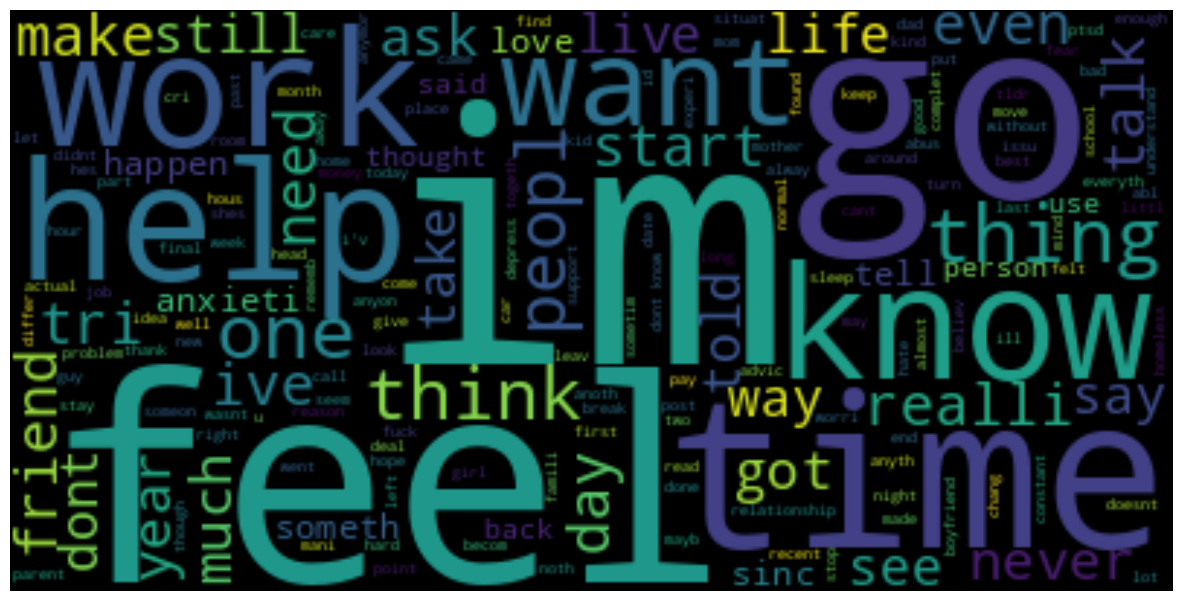

In [199]:
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [200]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)",said felt way sugget go rest trigger ahead you...,1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)",hey rassist sure right place post goe im curr...,0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",mom hit newspap shock would know dont like pla...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]",met new boyfriend amaz kind sweet good student...,1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",octob domest violenc awar month domest violenc...,1,0.8,1539809005


In [201]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # más uno para marcar el final.
def unicodeToAscii(s):
    '''
    Función auxiliar para transformae elementos de UNICODE a ASCII
    '''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
def normalizeLines(lines):
    return [int.from_bytes(unicodeToAscii(line).encode()) for line in lines]

In [202]:
data = pd.read_csv("data/Stress.csv")
print(data.shape[0])


"""
Para esta primer versión utilizaremos el fragmento de texto y su relación
binaria de estrés o no estrés
FYI: Espero tener el suficiente tiempo para implementar una version que recoja mas datos
y realizar una comparativa entre ambas

---
Cambio
---
Es posible que sea necesario utilizar más datos para mejorar el aprendizaje
---
Convertimos un fragmento seleccionado al azar compuesto por un fragmento pequeno
previamente mostrado en el sentence range.
"""
import sys
sys.set_int_max_str_digits(0)#increase limit of digits for calcs

datay=data[data.columns[4]]#Columna con label (0,1) estres o no estres
datax=data.drop(columns=["label", "post_id", "sentence_range", "social_timestamp"]) #Columna con datos de salida
#datax.head()
sentence_range_list=list(data["sentence_range"])
subreddit_list=list(datax["subreddit"])
text_list=list(datax["text"])
confidence_list=list(datax["confidence"])

text_unicode=[]
#transformando a ascii
filas=0
for t,m in zip(text_list,sentence_range_list):
    m=m[1:-1]
    x1,x2= tuple(map(int, m.split(', ')))
    minilist_words=t.strip()[x1:x2]
    int_text=normalizeLines(unicodeToAscii(minilist_words.strip()))
    #print(int_text)
    big_str=''
    limit=0
    for i in int_text:
        big_str+=str(i)
        limit+=1
        if big_str=='':
            big_str+='z'
            #continue
    #try:
        text_unicode.append(int(big_str))
    #except ValueError:
    #    continue
    #filas+=1

datax = pd.DataFrame(list(zip(text_unicode, subreddit_list, confidence_list)))
datax.head()

2838


,0,1,2
0,110,ptsd,0.8
1,110111,assistance,1.0
2,110111116,ptsd,0.8
3,11011111632,relationships,0.6
4,11011111632102,survivorsofabuse,0.8


# One Hot Encoding
Convertimos en OneHot encoding la columna del texto

In [203]:
datax=pd.get_dummies(datax)
datax.head()

,0,2,1_almosthomeless,1_anxiety,1_assistance,1_domesticviolence,1_food_pantry,1_homeless,1_ptsd,1_relationships,1_stress,1_survivorsofabuse
0,110,0.8,False,False,False,False,False,False,True,False,False,False
1,110111,1.0,False,False,True,False,False,False,False,False,False,False
2,110111116,0.8,False,False,False,False,False,False,True,False,False,False
3,11011111632,0.6,False,False,False,False,False,False,False,True,False,False
4,11011111632102,0.8,False,False,False,False,False,False,False,False,False,True


# Escalado de datos
Ahora escalaremos los datos para que queden dentro de un rango mas corto

In [204]:
escalador = StandardScaler()
datax.columns = datax.columns.astype(str)
datax = escalador.fit_transform(datax)
print(datax)

[[-0.19963316 -0.05068596 -0.17031302 ... -0.49139578 -0.15189265
  -0.30738437]
 [-0.19963315  1.0792119  -0.17031302 ... -0.49139578 -0.15189265
  -0.30738437]
 [-0.19962586 -0.05068596 -0.17031302 ... -0.49139578 -0.15189265
  -0.30738437]
 ...
 [-0.19963315  1.0792119  -0.17031302 ... -0.49139578 -0.15189265
  -0.30738437]
 [-0.199626   -1.3419978   5.87154154 ... -0.49139578 -0.15189265
  -0.30738437]
 [-0.19247173 -1.3419978  -0.17031302 ... -0.49139578 -0.15189265
  -0.30738437]]


# Dividir datos entre entrenamiento y tests

In [205]:
datax.shape[0]

2838

In [206]:
#datay=datay[:datax.shape[0]]
datay.shape

(2838,)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size = 0.2, random_state = 2)

In [208]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X Train: (2270, 12), X Test: (568, 12), y_train: (2270,), y_test: (568,)


In [209]:
n_entradas =X_train.shape[1]
print(n_entradas)

12


# Conversion a tensores

In [210]:
t_X_train = torch.from_numpy(X_train).float().to("cpu") #MPS
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(y_train.values).float().to("cpu")
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]

In [211]:
test = TensorDataset(t_X_test, t_y_test)
print(test[0])

(tensor([-0.1996, -1.3420, -0.1703,  2.1546, -0.3367, -0.3540, -0.1149, -0.2508,
        -0.5090, -0.4914, -0.1519, -0.3074]), tensor([0.]))


In [212]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 24)
        self.linear2 = nn.Linear(24, 8)
        self.linear3 = nn.Linear(8, 1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))
        return pred_f

In [213]:
lr = 0.0001#Con este learning rate la RN se situó por el 61%
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()#Utilizamos BinaryCross porque devolvemos stressed or not stressed
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entrenando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=12, out_features=24, bias=True)
  (linear2): Linear(in_features=24, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=1, bias=True)
)
Entrenando el modelo

Epoch 100 	 Loss: 0.691
Accuracy: 51.23239517211914

Epoch 200 	 Loss: 0.6902
Accuracy: 51.23239517211914

Epoch 300 	 Loss: 0.6892
Accuracy: 51.23239517211914

Epoch 400 	 Loss: 0.688
Accuracy: 51.056339263916016

Epoch 500 	 Loss: 0.6864
Accuracy: 51.93661880493164

Epoch 600 	 Loss: 0.6846
Accuracy: 54.75352096557617

Epoch 700 	 Loss: 0.6826
Accuracy: 58.2746467590332

Epoch 800 	 Loss: 0.6805
Accuracy: 57.74647903442383

Epoch 900 	 Loss: 0.6784
Accuracy: 58.97887420654297

Epoch 1000 	 Loss: 0.6765
Accuracy: 60.21126937866211

Epoch 1100 	 Loss: 0.6749
Accuracy: 61.7957763671875

Epoch 1200 	 Loss: 0.6736
Accuracy: 61.7957763671875

Epoch 1300 	 Loss: 0.6725
Accuracy: 61.7957763671875

Epoch 1400 	 Loss: 0.6717
Accuracy: 61.7957763671875

Ep

# Graficando

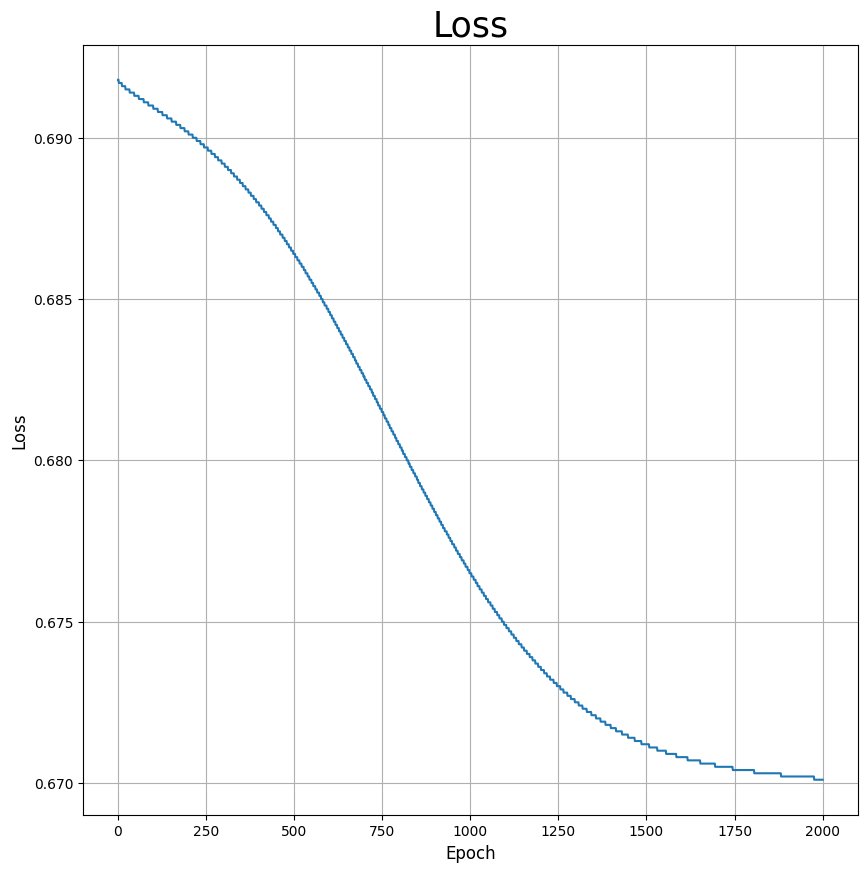

In [214]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

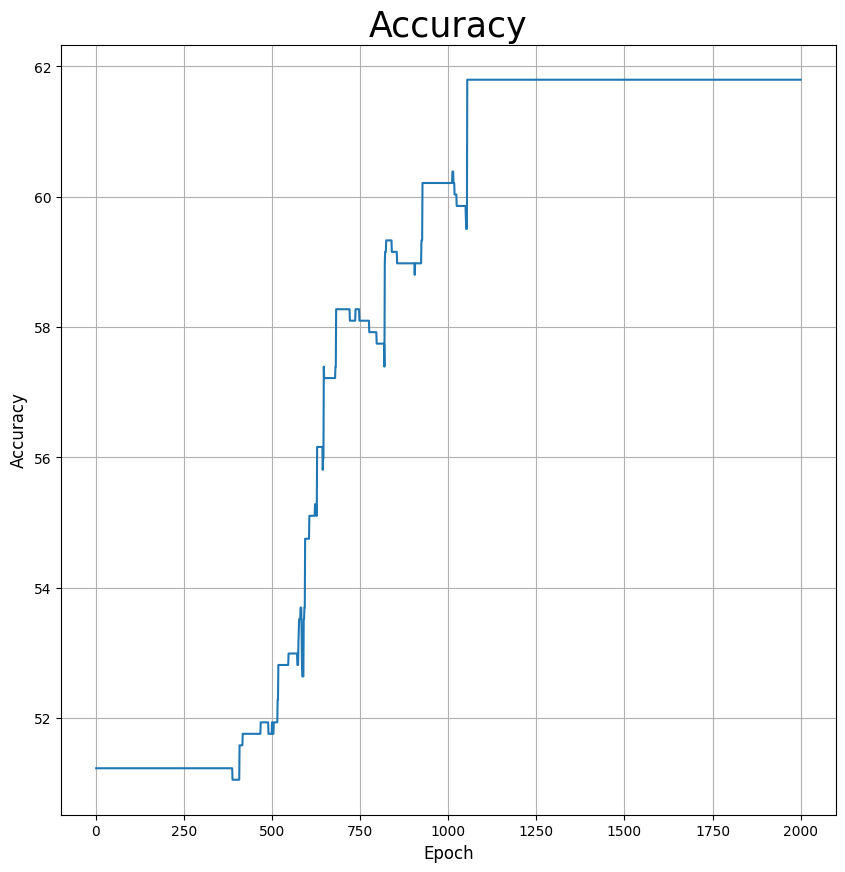

In [215]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

In [216]:
t_X_test[5]

tensor([-0.1996,  1.0792, -0.1703, -0.4641, -0.3367, -0.3540, -0.1149, -0.2508,
        -0.5090,  2.0350, -0.1519, -0.3074])

In [217]:
prediccion = model(t_X_test[5])
print(prediccion)

tensor([0.4835], grad_fn=<SigmoidBackward0>)


In [218]:
t_y_test[5]

tensor([0.])

# Red neuronal recurrente
Ahora crearemos la infraestructura de una RNR para el PLN y así poder realizar una comparación de accuracy

In [219]:
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)


In [220]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    datos = pd.read_csv("data/Stress.csv")
    datos["new_label"] = datos["label"].map({0: "No-Stress", 1: "Stress"})
    datos = datos[["text", "new_label"]]
    texto=list(datos["text"])
    label=list(datos["new_label"])
    stressed_text=[]
    non_stressed_text=[]
    for s,n in zip(texto,label):
        if n=="No-Stress":
            non_stressed_text.append(s)
        else:
            stressed_text.append(s)
    category_lines={"No-Stress": non_stressed_text, "Stress":stressed_text}
    return category_lines, ["No-Stress", "Stress"]

In [221]:
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [222]:
print(ALL_LETTERS)
print(unicodeToAscii('Ślusàrski'))
category_lines, all_categories = load_data()
#print(category_lines["No-Stress"]) # It explodes when you quit comment     
print(letter_to_tensor('J')) # [1, 57]
print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [223]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [224]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)

# whole sequence/name
input_tensor = line_to_tensor('Hi there')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output)

tensor([[-0.6820, -0.7044]], grad_fn=<LogSoftmaxBackward0>)


In [232]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.0005 #Utilizo el mismo learning rate que la otra RN
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

Stress


100 0.1 0.7777 / Stress WRONG (No-Stress)
200 0.2 0.6463 / Stress CORRECT
300 0.3 0.7964 / Stress WRONG (No-Stress)
400 0.4 0.6787 / Stress CORRECT
500 0.5 0.6701 / Stress CORRECT
600 0.6 0.7607 / Stress WRONG (No-Stress)
700 0.7000000000000001 0.7848 / Stress WRONG (No-Stress)
800 0.8 0.6485 / Stress CORRECT
900 0.8999999999999999 0.7345 / Stress WRONG (No-Stress)
1000 1.0 0.7157 / Stress WRONG (No-Stress)
1100 1.0999999999999999 0.6949 / Stress WRONG (No-Stress)
1200 1.2 0.6861 / Stress CORRECT
1300 1.3 0.6981 / No-Stress WRONG (Stress)
1400 1.4000000000000001 0.7615 / Stress WRONG (No-Stress)
1500 1.5 0.7219 / No-Stress WRONG (Stress)
1600 1.6 0.7193 / Stress WRONG (No-Stress)
1700 1.7000000000000002 0.6979 / No-Stress WRONG (Stress)
1800 1.7999999999999998 0.7245 / Stress WRONG (No-Stress)
1900 1.9 0.6340 / Stress CORRECT
2000 2.0 0.6626 / Stress CORRECT
2100 2.1 0.6412 / Stress CORRECT
2200 2.1999999999999997 0.7019 / Stress WRONG (No-Stress)
2300 2.3 0.7220 / Stress WRONG (No-Str

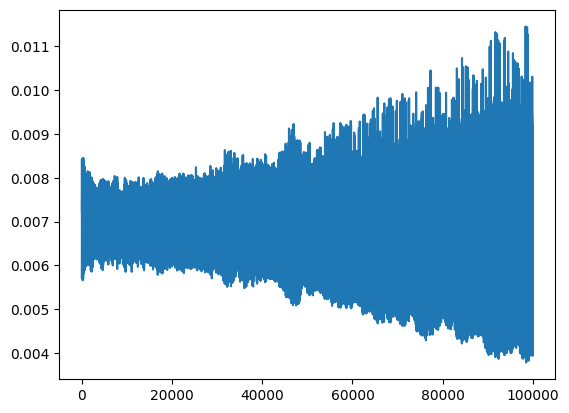

In [234]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 100,100
n_iters = 10000
good_responses=0
total_done=0
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    all_losses.append(current_loss / plot_steps)
    current_loss = 0    
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} / {guess} {correct}")
    guess = category_from_output(output)
    if guess == category:
        good_responses+=1
    total_done=good_responses/n_iters

print("Acuraccy: ", total_done*100.0, "% Correct", )
 
print("Acuraccy: ", good_responses ,"/ ",n_iters )
        
    
plt.figure()
plt.plot(all_losses)
plt.show()

In [235]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)
        
predict("Barbie looks really ugly")


> Barbie looks really ugly
No-Stress


In [236]:
predict("I hate when you tell I'm not enough for you")


> I hate when you tell I'm not enough for you
Stress


In [238]:
predict("Where is my money I'm in a hurry???")


> Where is my money I'm in a hurry???
No-Stress


In [239]:
predict("I'm really nervous, Are you leaving me?")


> I'm really nervous, Are you leaving me?
Stress
